In [1]:
import pandas as pd

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from itertools import islice
import random
import numpy as np
import torch

In [3]:
import mne
mne.set_log_level('ERROR')
import warnings
warnings.filterwarnings('ignore')

from braindecode.datautil.serialization import load_concat_dataset
from gluonts.dataset.common import ListDataset
from collections import namedtuple


In [4]:
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.repository.datasets import get_dataset
from pytorch_lightning.loggers import WandbLogger, CSVLogger

from estimator import LagGPTEstimator

In [5]:
from pathlib import Path
from gluonts.dataset.repository.datasets import get_download_path
# get_download_path()

# create a Path object for the desired folder
gluonts_data_path = Path("~/scratch/gluonts").expanduser()


In [6]:
class CombinedDatasetIterator:
    def __init__(self, datasets, seed, weights):
        self._datasets = [iter(el) for el in datasets]
        self._weights = weights
        self._rng = random.Random(seed)

    def __next__(self):
        (dataset,) = self._rng.choices(self._datasets, weights=self._weights, k=1)
        return next(dataset)

In [7]:
class CombinedDataset:
    def __init__(self, datasets, seed=None, weights=None):
        self._seed = seed
        self._datasets = datasets
        self._weights = weights
        n_datasets = len(datasets)
        if weights is None:
            self._weights = [1 / n_datasets] * n_datasets

    def __iter__(self):
        return CombinedDatasetIterator(self._datasets, self._seed, self._weights)
    
    def __len__(self):
        return sum([len(ds) for ds in self._datasets])

In [8]:
# define a namedtuple class to store the train and test datasets
BrainDecodeDataset = namedtuple("BrainDecodeDataset", ["train", "test"])

def get_braindecode_dataset(path, preload=True, ids_to_load=None, target_name=None, freq="1S"): #[TODO: freq should be 100Hz but the code can not handle it]
    """
    Load a braindecode dataset from files and convert it to a gluonts dataset.

    Parameters
    ----------
    path : str
        The path to the directory of the .fif / -epo.fif and .json files.
        First run eeg_preprocessing.ipynb to conver .edf files to .fif
    preload : bool, optional
        Whether to preload the data or not. Default is True.
    ids_to_load : list of int, optional
        The ids of specific files to load. Default is None, which means all files are loaded.
    target_name : str, optional
        The target name to load. Only for raws. Default is None, which means the last channel is used as the target.
    freq : str, optional
        The frequency of the time series. Default is "1S", which means one sample per second.
    test_ratio : float, optional
        The ratio of the test set size to the total dataset size. Default is 0.2, which means 20% of the data is used for testing.

    Returns
    -------
    BrainDecodeDataset
        A namedtuple object that contains the train and test datasets as ListDataset objects.
    """
    # load the dataset as a BaseConcatDataset object
    dataset = load_concat_dataset(path, preload, ids_to_load, target_name)

    train_set = dataset.split('train')['True']
    test_set = dataset.split('train')['False']

    # convert the dataset to a list of dictionaries with 'target' and 'start' keys
    data_list = []
    for ds in train_set.datasets:
        # get the target values as a numpy array
        target = ds.raw.get_data()[0]
        # get the start time as a pandas timestamp
        start = ds.raw.info["meas_date"]
        # append the dictionary to the list
        data_list.append({"target": target, "start": start})

    # convert the lists to ListDataset objects
    train_dataset = ListDataset(data_list, freq=freq)

    # convert the dataset to a list of dictionaries with 'target' and 'start' keys
    data_list = []
    for ds in test_set.datasets:
        # get the target values as a numpy array
        target = ds.raw.get_data()[0]
        # get the start time as a pandas timestamp
        start = ds.raw.info["meas_date"]
        # append the dictionary to the list
        data_list.append({"target": target, "start": start})

    # convert the lists to ListDataset objects
    test_dataset = ListDataset(data_list, freq=freq)


    # create a BrainDecodeDataset object with the train and test datasets
    braindecode_dataset = BrainDecodeDataset(train=train_dataset, test=test_dataset)

    # return the braindecode dataset
    return braindecode_dataset


In [9]:
gluonts_ds = [
        get_dataset("airpassengers",path=gluonts_data_path).train,
        # get_dataset("australian_electricity_demand",path=gluonts_data_path).train,
        # get_dataset("car_parts_without_missing",path=gluonts_data_path).train,
        # get_dataset("cif_2016",path=gluonts_data_path).train,
        # get_dataset("covid_deaths",path=gluonts_data_path).train,
        # get_dataset("electricity",path=gluonts_data_path).train,
        # get_dataset("electricity_weekly",path=gluonts_data_path).train,
        # get_dataset("exchange_rate",path=gluonts_data_path).train,
        # get_dataset("fred_md",path=gluonts_data_path).train,
        # get_dataset("hospital",path=gluonts_data_path).train,
        # get_dataset("kaggle_web_traffic_weekly",path=gluonts_data_path).train,
        # get_dataset("kdd_cup_2018_without_missing",path=gluonts_data_path).train,
        # get_dataset("london_smart_meters_without_missing",path=gluonts_data_path).train,
        # get_dataset("nn5_daily_with_missing",path=gluonts_data_path).train,
        # get_dataset("nn5_weekly",path=gluonts_data_path).train,
        # get_dataset("pedestrian_counts",path=gluonts_data_path).train,
        # get_dataset("rideshare_without_missing",path=gluonts_data_path).train,
        # get_dataset("saugeenday",path=gluonts_data_path).train,
        # get_dataset("solar-energy",path=gluonts_data_path).train,
        # get_dataset("solar_10_minutes",path=gluonts_data_path).train,
        # get_dataset("solar_weekly",path=gluonts_data_path).train,
        # get_dataset("taxi_30min",path=gluonts_data_path).train,
        # get_dataset("temperature_rain_without_missing",path=gluonts_data_path).train,
        # get_dataset("tourism_monthly",path=gluonts_data_path).train,
        # get_dataset("uber_tlc_daily",path=gluonts_data_path).train,
        # get_dataset("uber_tlc_hourly",path=gluonts_data_path).train,
        # get_dataset("vehicle_trips_without_missing",path=gluonts_data_path).train,
        # get_dataset("weather",path=gluonts_data_path).train,
        # get_dataset("wiki-rolling_nips",path=gluonts_data_path).train,
        # get_dataset("m4_daily",path=gluonts_data_path).train,
        # get_dataset("m4_hourly",path=gluonts_data_path).train,
        # get_dataset("m4_monthly",path=gluonts_data_path).train,
        # get_dataset("m4_quarterly",path=gluonts_data_path).train,
        # get_dataset("m4_yearly",path=gluonts_data_path).train,
        # get_dataset("wind_farms_without_missing",path=gluonts_data_path).train,
        get_braindecode_dataset(path=Path("~/scratch/medical/eeg/tuab/tuab_pp3/").expanduser(),
                                preload=True, ids_to_load=range(10), target_name=None, freq="1S").train,
]
train_dataset = CombinedDataset(gluonts_ds, weights=[sum([len(x["target"]) for x in d]) for d in gluonts_ds])

In [10]:
# val_dataset = get_dataset("m4_weekly", path=gluonts_data_path).test
val_dataset = get_braindecode_dataset(path=Path("~/scratch/medical/eeg/tuab/tuab_pp3/").expanduser(),
                                preload=True, ids_to_load=range(10), target_name=None, freq="1S").test

adding tuab as a gluonts ds

In [11]:
# continue_TF = True
# assert continue_TF==True

In [12]:
meta = get_dataset("m4_weekly", path=gluonts_data_path).metadata

In [13]:
meta

MetaData(freq='W', target=None, feat_static_cat=[CategoricalFeatureInfo(name='feat_static_cat_0', cardinality='359')], feat_static_real=[], feat_dynamic_real=[], feat_dynamic_cat=[], prediction_length=13)

In [14]:
#set more seeds
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
logger = CSVLogger("logs", name="Lag-gpt-large-"+str(seed))

In [15]:
!unset LD_LIBRARY_PATH

In [16]:
estimator = LagGPTEstimator(
    prediction_length=meta.prediction_length,
    context_length=1024, # block_size: int = 1024, 2048 
    batch_size=64, # 4, 8, 16, 32
    n_layer=8,
    n_head=4,
    n_embd=32, # 32,64,128,256,512,1024,2048,4096
    scaling="std",
    
    # set aug prob
    aug_prob=1.0,
    aug_rate=0.1,
    
    num_batches_per_epoch=100,
    trainer_kwargs=dict(max_epochs=5, accelerator="gpu", precision="32", logger=logger),
)

In [17]:
predictor = estimator.train(
    training_data=train_dataset, 
    validation_data=val_dataset,
    shuffle_buffer_length=1000
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type        | Params
--------------------------------------
0 | model | LagGPTModel | 232 K 
--------------------------------------
232 K     Trainable params
0         Non-trainable params
232 K     Total params
0.931     Total estimated model params size (MB)


Epoch 0: : 100it [00:20,  4.99it/s, v_num=27, val_loss=0.733, train_loss=1.040]

Epoch 0, global step 100: 'val_loss' reached 0.73305 (best 0.73305), saving model to 'logs/Lag-gpt-large-42/version_27/checkpoints/epoch=0-step=100.ckpt' as top 1


Epoch 1: : 100it [00:20,  4.92it/s, v_num=27, val_loss=0.686, train_loss=0.946]

Epoch 1, global step 200: 'val_loss' reached 0.68627 (best 0.68627), saving model to 'logs/Lag-gpt-large-42/version_27/checkpoints/epoch=1-step=200.ckpt' as top 1


Epoch 2: : 100it [00:20,  4.83it/s, v_num=27, val_loss=0.696, train_loss=0.923]

Epoch 2, global step 300: 'val_loss' was not in top 1


Epoch 3: : 100it [00:21,  4.75it/s, v_num=27, val_loss=0.705, train_loss=0.910]

Epoch 3, global step 400: 'val_loss' was not in top 1


Epoch 4: : 100it [00:21,  4.72it/s, v_num=27, val_loss=0.692, train_loss=0.892]

Epoch 4, global step 500: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: : 100it [00:21,  4.71it/s, v_num=27, val_loss=0.692, train_loss=0.892]


In [18]:
# test_dataset = get_dataset("pedestrian_counts", path=gluonts_data_path).test
test_dataset = get_braindecode_dataset(path=Path("~/scratch/medical/eeg/NMT/nmt_pp3/").expanduser(),
                                preload=True, ids_to_load=range(500), target_name=None, freq="1S").test

In [19]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_dataset, predictor=predictor
)

In [20]:
forecasts = list(forecast_it)

In [21]:
tss = list(ts_it)

In [22]:
evaluator = Evaluator()
agg_metrics, ts_metrics = evaluator(
    iter(tss), iter(forecasts), num_series=len(test_dataset)
)

Running evaluation: 100%|██████████| 41/41 [00:22<00:00,  1.79it/s]


In [23]:
agg_metrics

{'MSE': 0.7370094007220098,
 'abs_error': 350.8921092748642,
 'abs_target_sum': 383.58132100105286,
 'abs_target_mean': 0.7196647673565719,
 'seasonal_error': 0.9650692340331885,
 'MASE': 0.6776041509216151,
 'MAPE': 50.083347213201186,
 'sMAPE': 1.3206024411471655,
 'MSIS': 5.837553212935709,
 'QuantileLoss[0.1]': 176.82414521425966,
 'Coverage[0.1]': 0.21200750469043156,
 'QuantileLoss[0.2]': 257.48251910768454,
 'Coverage[0.2]': 0.27767354596622895,
 'QuantileLoss[0.3]': 306.0908255483955,
 'Coverage[0.3]': 0.3602251407129456,
 'QuantileLoss[0.4]': 337.04895654805006,
 'Coverage[0.4]': 0.4427767354596623,
 'QuantileLoss[0.5]': 350.89210881711915,
 'Coverage[0.5]': 0.50093808630394,
 'QuantileLoss[0.6]': 346.6437837716192,
 'Coverage[0.6]': 0.5497185741088181,
 'QuantileLoss[0.7]': 322.8531543634832,
 'Coverage[0.7]': 0.622889305816135,
 'QuantileLoss[0.8]': 276.7276966169476,
 'Coverage[0.8]': 0.6791744840525329,
 'QuantileLoss[0.9]': 194.56984787657854,
 'Coverage[0.9]': 0.76735459

In [24]:
metric_type = []
error = []
for state in agg_metrics:
    metric_type.append(state)
for value in agg_metrics.values():
    error.append(value)

In [25]:
df = pd.DataFrame( error, metric_type).reset_index().rename(columns = {'index': 'error',0:'metric_type'}).T
df.columns = df.iloc[0,:]
df = df.iloc[1:, :]
df['#parameters']=411000000#102000000#411000000#6800000
df['seed'] = seed
df.to_csv('error100.csv')

In [26]:
dff = pd.read_csv('error100.csv')#.drop('Unnamed: 0', axis=1)
# dff.columns
dff = dff.append(df)
dff.to_csv('error100.csv', index=False)

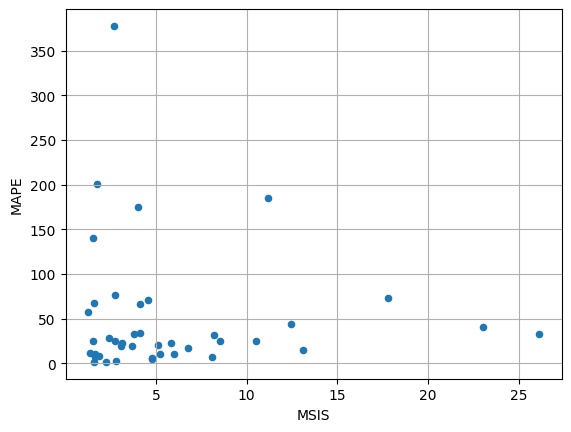

In [27]:
ts_metrics.plot(x="MSIS", y="MAPE", kind="scatter")
plt.grid(which="both")
plt.show()

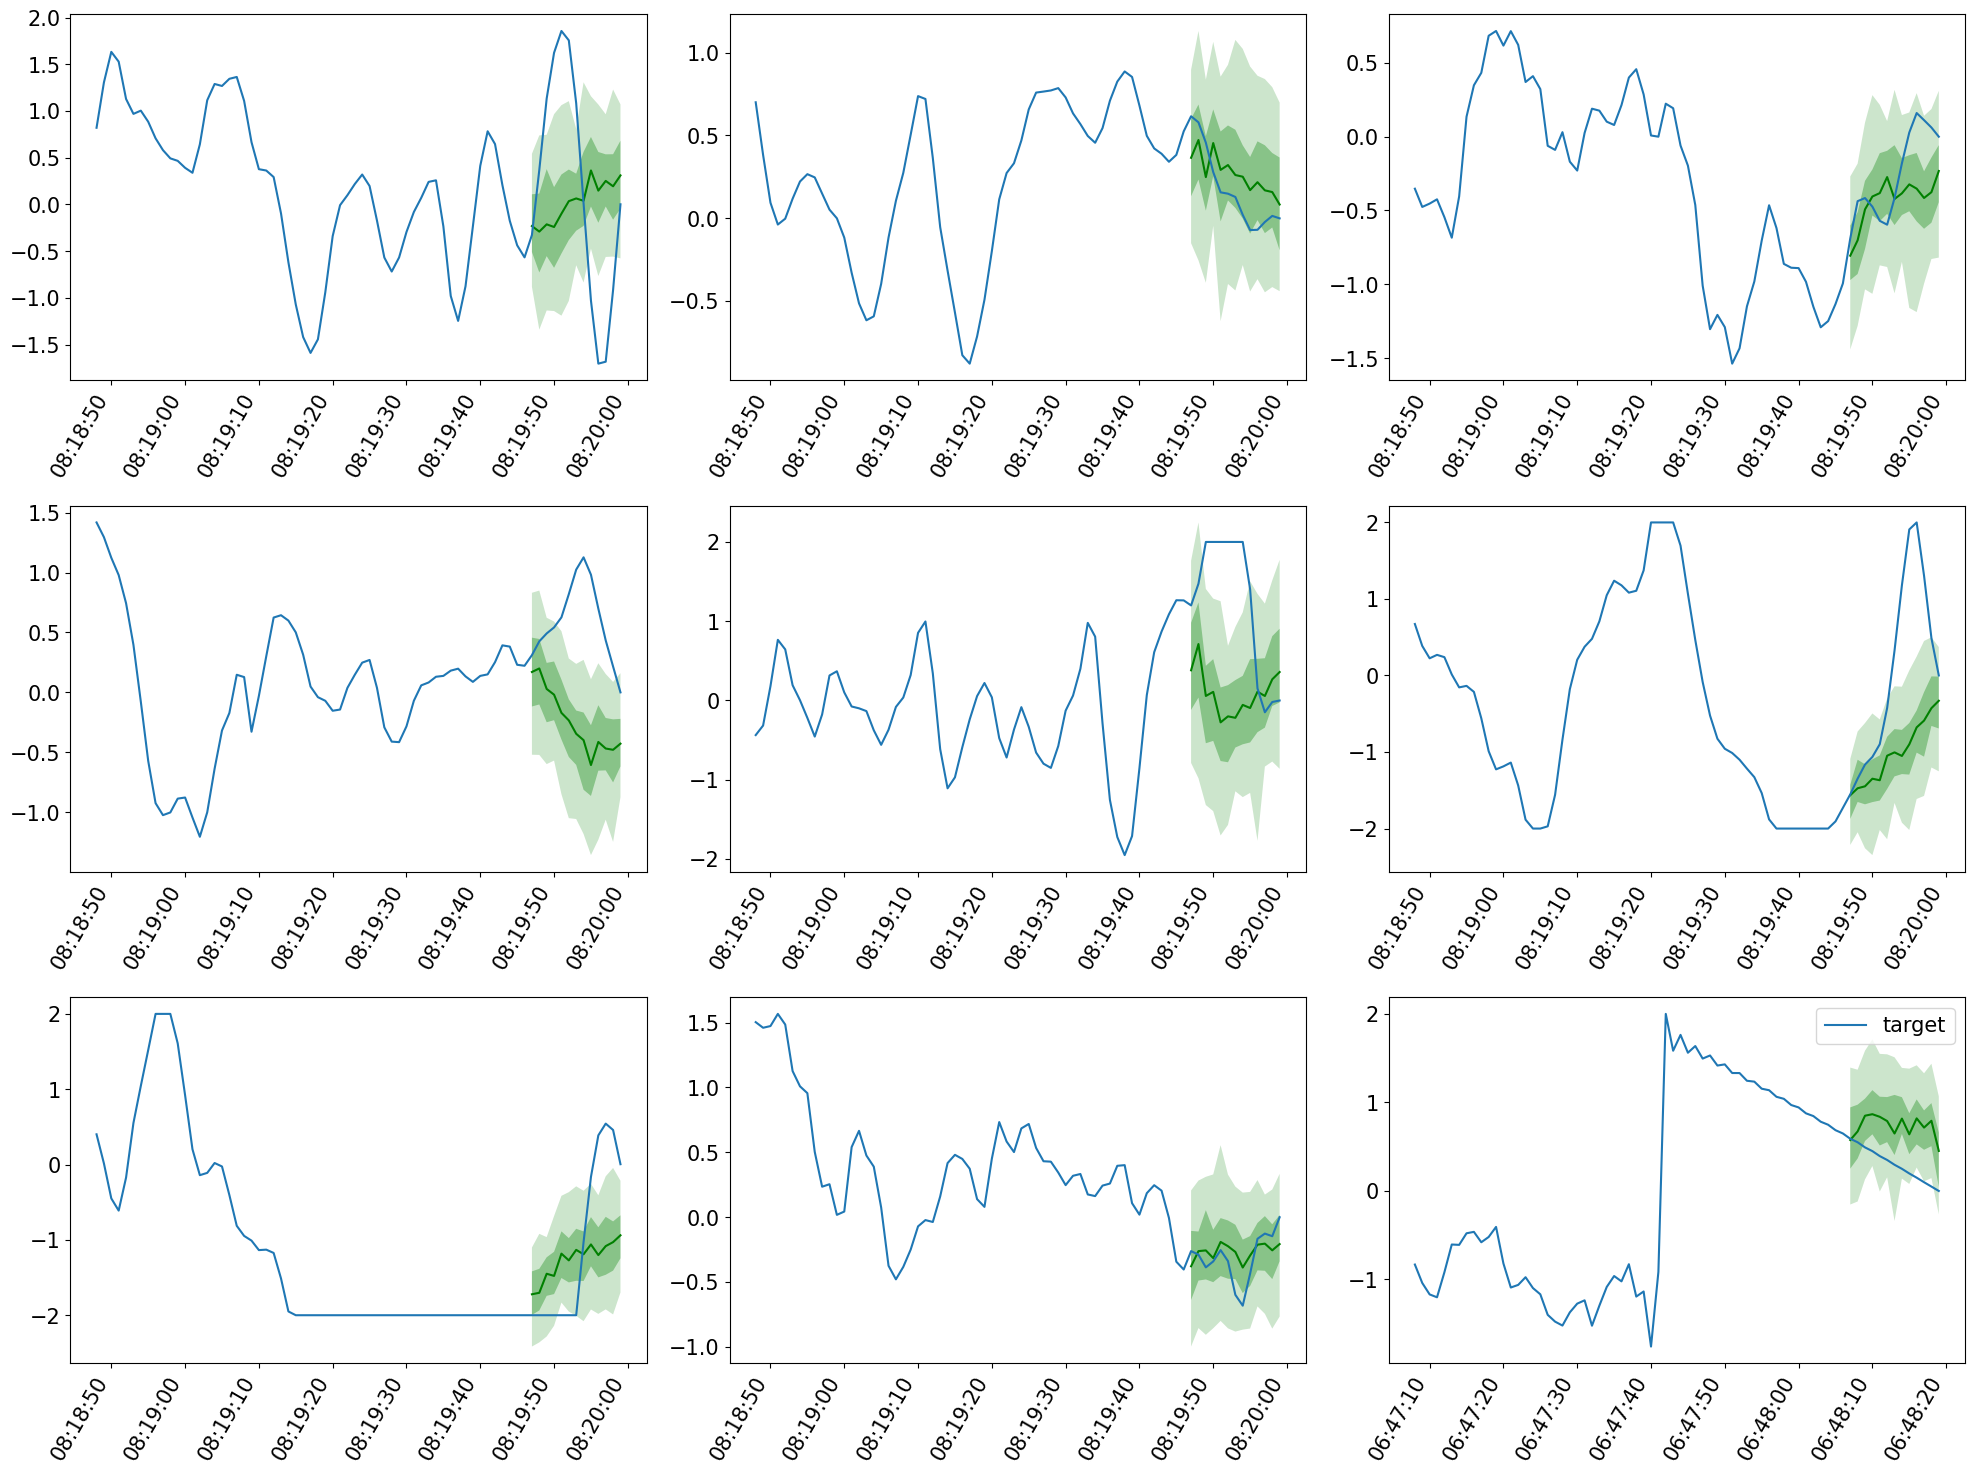

In [28]:
plt.figure(figsize=(20, 15))
plt.rcParams.update({'font.size': 15})

for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)
    forecast.plot(color='g')
    ts[-3 * 24:][0].plot(label="target")
    plt.xticks(rotation=60)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

In [29]:
df = pd.read_csv('error100.csv')
df = df.drop_duplicates(subset=['#parameters','seed'], keep='last')
temp = df.groupby(['#parameters'])['RMSE'].mean().reset_index().dropna()
std_temp = df.groupby(['#parameters'])['RMSE'].std().reset_index()

In [30]:
temp

,#parameters,RMSE
0,411000000,0.858493


In [31]:
std_temp

,#parameters,RMSE
0,411000000,NaN


<Figure size 640x480 with 0 Axes>

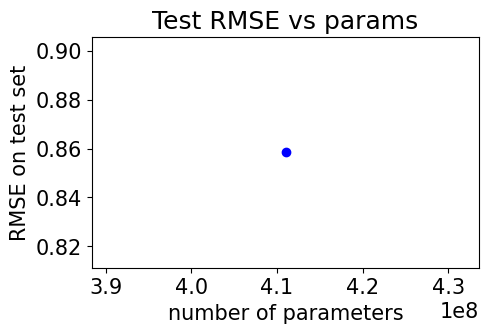

In [32]:
plt.clf()
fig = plt.subplots(figsize =(5, 3))# large

# plt.bar(temp['model'],temp['crps'],width = 0.2)
plt.plot(temp['#parameters'],temp['RMSE'],'bo-')
for x,y in zip(np.log10(temp['#parameters']),[0,0.1,0.5]):

    label = f"p={y}"

    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') 
plt.title('Test RMSE vs params')
plt.xlabel('number of parameters')
plt.ylabel('RMSE on test set')
plt.show()

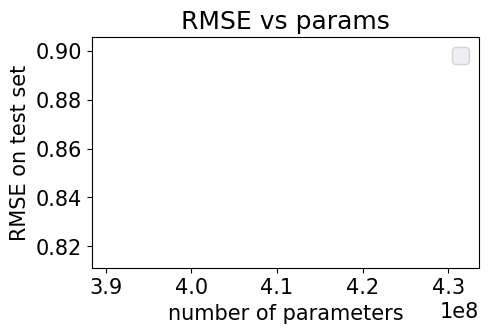

In [33]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(5,3))
clrs = sns.color_palette("husl", 5)
with sns.axes_style("darkgrid"):
    ax.plot(temp['#parameters'], temp['RMSE'])
    ax.fill_between(temp['#parameters'], temp['RMSE']-std_temp['RMSE'], temp['RMSE']+std_temp['RMSE'] ,alpha=0.3)
    ax.legend()
plt.title('RMSE vs params')
plt.xlabel('number of parameters')
plt.ylabel('RMSE on test set')
plt.show()
    # ax.set_yscale('log')

In [34]:
import os
path = "logs/"
dir_list = os.listdir(path)
dir_list

['Lag-gpt-large-42']

In [35]:
dff = pd.DataFrame()
for i in dir_list:
    
    df = pd.read_csv('logs/'+i+'/version_0/metrics.csv').drop(['train_loss'], axis=1).dropna()
    df['seed']=int(i.split("-")[-1])
    if i.split("-")[-2]=='medium':
        df['parameters']=102000000
    if i.split("-")[-2]=='small':
        print(i)
        df['parameters']=6800000
    if i.split("-")[-2]=='large':
        df['parameters']=411000000
    dff = dff.append(df, ignore_index=True)


In [36]:
dff['parameters'].unique().tolist()

[411000000]

In [37]:
temp = dff.groupby(['parameters','epoch'])['val_loss'].mean().reset_index().dropna()
std_temp = dff.groupby(['parameters','epoch'])['val_loss'].std().reset_index().dropna()


In [38]:
temp

,parameters,epoch,val_loss
0,411000000,0,7.899902
1,411000000,1,7.701183


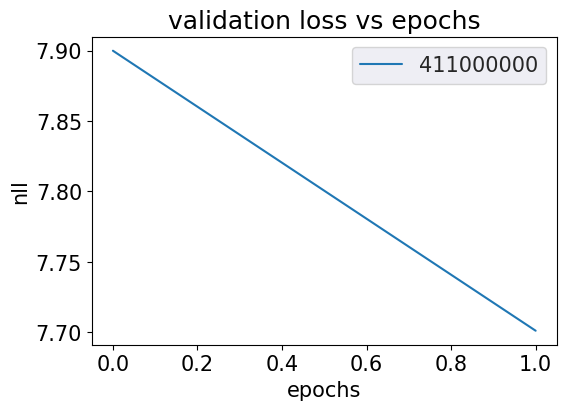

In [39]:
fig, ax = plt.subplots(figsize=(6,4))
clrs = sns.color_palette("husl", 5)
with sns.axes_style("darkgrid"):
    for i in dff['parameters'].unique().tolist():
        ax.plot(temp[temp['parameters']==i]['epoch'], temp[temp['parameters']==i]['val_loss'], label=i)
        ax.fill_between(temp[temp['parameters']==i]['epoch'], temp[temp['parameters']==i]['val_loss']-std_temp[std_temp['parameters']==i]['val_loss'], temp[temp['parameters']==i]['val_loss']+std_temp[std_temp['parameters']==i]['val_loss'] ,alpha=0.3)
        ax.legend()
plt.title('validation loss vs epochs')
plt.xlabel('epochs')
plt.ylabel('nll')
plt.show()